In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [83]:
import os

In [ ]:
os.path.join('data', 'happy')

'data/happy'

In [ ]:
import imghdr

/tmp/ipython-input-4-336752527.py:1: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/Data'
print(os.listdir(data_dir))          # ['happy', 'sad']



['sad people', 'Happy People']


Removing Dodgy Images

In [ ]:
image_exts = ['jpeg', 'jpg', 'png', 'bmp']

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))
        # os.remove(image_path)


In [ ]:
data = tf.keras.utils.image_dataset_from_directory??

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 208 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

Class 0 = Happy People
Class 1 = Sad People

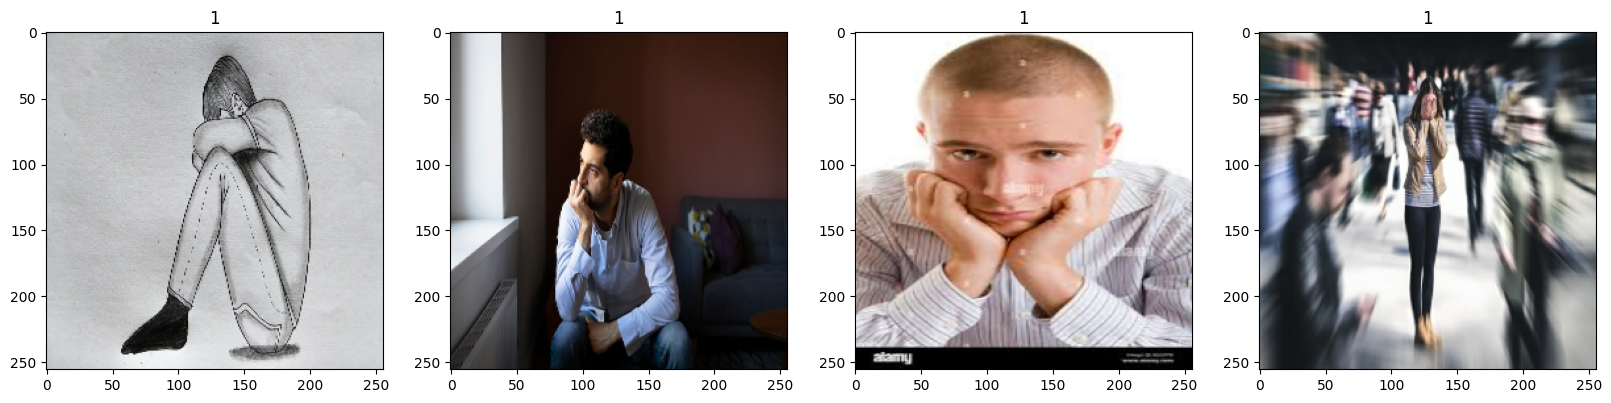

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Scale Data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

In [ ]:
batch[1].max()

np.int32(1)

Splitting Data

In [ ]:
len(data)

7

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [ ]:
train_size+val_size+test_size

7

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Building DEEP learning model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Training the model

In [ ]:
import datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.3927 - loss: 2.0276 - val_accuracy: 0.3125 - val_loss: 1.0767
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4948 - loss: 0.8233 - val_accuracy: 0.6875 - val_loss: 0.6679
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6479 - loss: 0.6461 - val_accuracy: 0.5938 - val_loss: 0.6108
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6448 - loss: 0.5964 - val_accuracy: 0.6562 - val_loss: 0.5617
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6187 - loss: 0.5868 - val_accuracy: 0.7656 - val_loss: 0.5655
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7771 - loss: 0.5097 - val_accuracy: 0.8750 - val_loss: 0.4120
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9156 - loss: 0.4018 - val_accuracy: 0.9531 - val_loss: 0.2970
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9135 - loss: 0.3206 - val_accuracy: 0.9219 - val_loss: 0.2268
Epoch 9/

In [ ]:
hist.history

{'accuracy': [0.4453125,
  0.53125,
  0.640625,
  0.640625,
  0.65625,
  0.75,
  0.9453125,
  0.9140625,
  0.8671875,
  0.9140625,
  0.9453125,
  0.9453125,
  0.984375,
  0.9609375,
  0.984375,
  0.96875,
  0.984375,
  0.9765625,
  0.9921875,
  0.9921875],
 'loss': [2.040926218032837,
  0.7667741775512695,
  0.6337755918502808,
  0.6347793340682983,
  0.5683387517929077,
  0.5102614760398865,
  0.3817444145679474,
  0.3165029287338257,
  0.30145832896232605,
  0.24660922586917877,
  0.21973039209842682,
  0.14307263493537903,
  0.09523533284664154,
  0.12016227841377258,
  0.08001360297203064,
  0.08435507863759995,
  0.07435759902000427,
  0.07357039302587509,
  0.06647184491157532,
  0.04381149634718895],
 'val_accuracy': [0.3125,
  0.6875,
  0.59375,
  0.65625,
  0.765625,
  0.875,
  0.953125,
  0.921875,
  0.796875,
  0.9375,
  0.9375,
  0.953125,
  0.875,
  1.0,
  0.984375,
  1.0,
  0.96875,
  0.96875,
  0.984375,
  1.0],
 'val_loss': [1.076737403869629,
  0.6679198741912842,
  0.

Plotting the performance

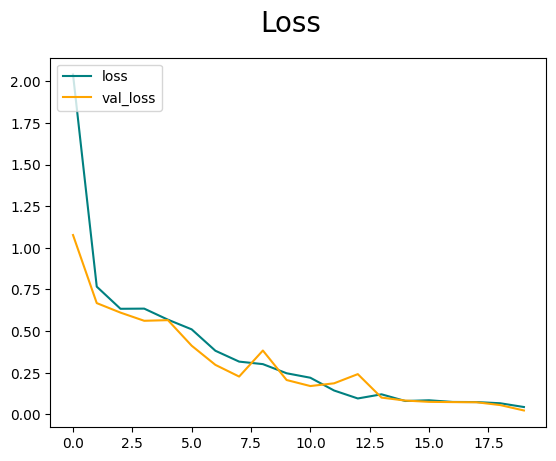

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

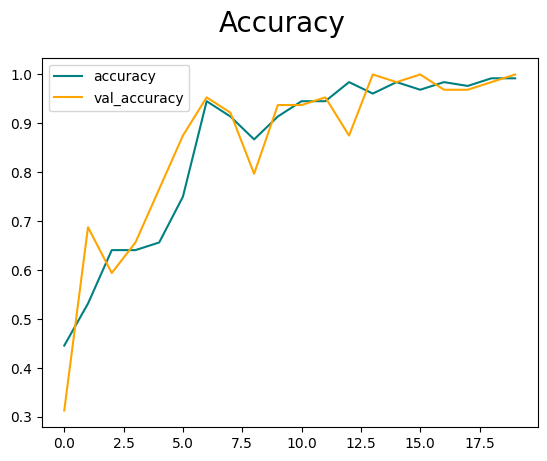

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [46]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [48]:
# Going through our testing data
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


In [49]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


Test

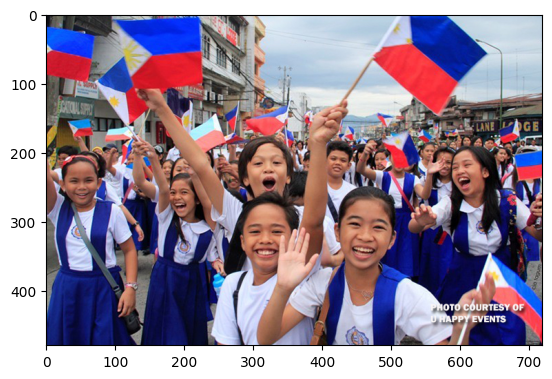

In [74]:
img = cv2.imread('happy3.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
plt.show()

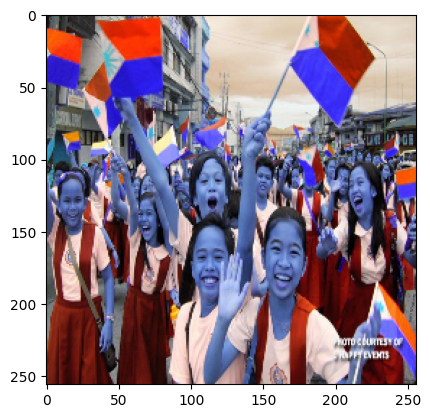

In [75]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [76]:
#because model expects a batch of input not just a single image
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [77]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [78]:
yhat

array([[0.00024071]], dtype=float32)

In [79]:
if yhat > 0.5:
  print('Predicted class is SAD!')
else:
  print('predicted class is HAPPY!')

predicted class is HAPPY!


Saving the model

In [81]:
from tensorflow.keras.models import load_model

In [86]:
model.save(os.path.join('models', 'happysadmodel.h5'))

Using the saved model

In [87]:
new_model = load_model(os.path.join('models', 'happysadmodel.h5'))

In [88]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


In [90]:
if yhat_new > 0.5:
  print('Predicted class is SAD!')
else:
  print('predicted class is HAPPY!')

predicted class is HAPPY!
